In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import astropy.units as u
import glob
import os
import subprocess

# Initialize Functions that Save and Show CM plots

Functions Below are initialized to make a color magnitude graphs based on stellar surface gravity and stellar temperature

In [47]:
def make_logg_CM(campaign, proposal, folder):
    """
    proposal should be entered as an int
    campaign and folder are strings
    """
    df_all = pd.read_csv('csv_files/%s/master_search.csv' %campaign, low_memory=False)

    df_big_proposal = pd.read_csv('csv_files/%s/big_targets/prop_%d.csv' %(campaign, proposal), low_memory=False, error_bad_lines=False)
    #Would want the above line to cycle through big_targets

    prop_id = df_big_proposal['EPIC ID']
    df_all = df_all.merge(df_big_proposal, left_on='EPIC', right_on='EPIC ID', how='inner')

    ww = np.where(df_all['Object type'] == 'STAR')
    df_all = df_all.iloc[ww]

    #initializing the data frame for calculating reduced proper motion
    df_pm = pd.DataFrame(columns=['Jmag','Hmag','KepMag','pmra','pmdec',
    'pm','j_min_h','H', 'logg'])

    df_pm['Jmag'] = df_all['Jmag']
    df_pm['Hmag'] = df_all['Hmag']
    df_pm['logg'] = df_all['logg']

    #Removing any row that doesn't have a Jmag and Hmag value
    df_pm = df_pm.dropna(axis=0, subset=['Jmag','Hmag'], how='any')

    df_pm['KepMag'] = df_all['KepMag']
    df_pm['pmra'] = df_all['pmra']
    df_pm['pmdec'] = df_all['pmdec']

    df_pm['j_min_h'] = df_pm['Jmag'] - df_pm['Hmag']

    #Need to calculate reduced proper motion make sure to add in quadrature
    #H = m + 5log(mu) + 5 (y-axis)
    df_pm = df_pm.dropna(axis=0, subset=['KepMag','pmra','pmdec'], how='any')
    
    #Sometimes proposals don't have any stars, despite being large so we return early if empty so no empty plots are made
    if df_pm.empty:
        return

    #use pmra and pmdec to get a total pm and conver mas/yr to arcsec/yr
    df_pm['pm'] = np.sqrt((((1/1000)*df_pm['pmra'])**2) + (((1/1000)*df_pm['pmdec'])**2))

    #pm is in mas/year so multiply by 1000
    df_pm['J'] = 5 + df_pm['Jmag'] + (5*(np.log(df_pm['pm'])))

    J = df_pm['J']
    j_min_h = df_pm['j_min_h']

    dd = np.where(df_pm['logg'] >= 4.0)
    gg = np.where(df_pm['logg'] <= 3.0)
    m = np.where(np.logical_and(df_pm['logg'] > 3.0, df_pm['logg'] < 4.0))
    
    #Change the line below for dwarfs and giants
    giants = df_pm.iloc[gg]
    dwarfs = df_pm.iloc[dd]
    mid = df_pm.iloc[m]

    J_gg = giants['J']
    j_min_h_gg = giants['j_min_h']

    J_dd = dwarfs['J']
    j_min_h_dd = dwarfs['j_min_h']

    J_mid = mid['J']
    j_min_h_mid = mid['j_min_h']

    plt.plot(j_min_h_dd, J_dd, '.', c='blue', alpha=0.3, label='dwarf')
    plt.plot(j_min_h_gg, J_gg, '.', c='green', alpha=0.3, label='giant')
    plt.plot(j_min_h_mid, J_mid, '.', c='yellow', alpha=0.3, label='mid')
    plt.ylim(reversed(plt.ylim()))
    plt.xlabel('J - H')
    plt.ylabel('J')
    plt.grid(True)
    plt.title('Campaign %s, Proposal %d' %(campaign, proposal))
    plt.legend(numpoints = 1)
    #plt.savefig('graphs/%s/%s/%d_color_mag_colorized' %(campaign, folder, proposal))
    plt.show()

In [48]:
def make_temp_CM(campaign, proposal, folder):
    """
    proposal should be entered as an int
    campaign and folder are strings
    """
    df_all = pd.read_csv('csv_files/%s/master_search.csv' %campaign, low_memory=False)
    
    #Would want the above line to cycle through big_targets
    df_big_proposal = pd.read_csv('csv_files/%s/big_targets/prop_%d.csv' %(campaign, proposal), low_memory=False)

    prop_id = df_big_proposal['EPIC ID']
    df_all = df_all.merge(df_big_proposal, left_on='EPIC', right_on='EPIC ID', how='inner')

    ww = np.where(df_all['Object type'] == 'STAR')
    df_all = df_all.iloc[ww]

    #initializing the data frame for calculating reduced proper motion
    df_pm = pd.DataFrame(columns=['Jmag','Hmag','KepMag','pmra','pmdec',
    'pm','j_min_h','H', 'Teff'])

    df_pm['Jmag'] = df_all['Jmag']
    df_pm['Hmag'] = df_all['Hmag']
    df_pm['Teff'] = df_all['Teff']


    #Removing any row that doesn't have a Jmag and Hmag value
    df_pm = df_pm.dropna(axis=0, subset=['Jmag','Hmag'], how='any')
    
    #Sometimes proposals don't have any stars, despite being large so we return early if empty so no empty plots are made
    if df_pm.empty:
        return

    df_pm['KepMag'] = df_all['KepMag']
    df_pm['pmra'] = df_all['pmra']
    df_pm['pmdec'] = df_all['pmdec']

    df_pm['j_min_h'] = df_pm['Jmag'] - df_pm['Hmag']

    #Need to calculate reduced proper motion make sure to add in quadrature
    #H = m + 5log(mu) + 5 (y-axis)
    df_pm = df_pm.dropna(axis=0, subset=['KepMag','pmra','pmdec'], how='any')

    #use pmra and pmdec to get a total pm and conver mas/yr to arcsec/yr
    df_pm['pm'] = np.sqrt((((1/1000)*df_pm['pmra'])**2) + (((1/1000)*df_pm['pmdec'])**2))

    #pm is in mas/year so multiply by 1000
    df_pm['J'] = 5 + df_pm['Jmag'] + (5*(np.log(df_pm['pm'])))
    #pdb.set_trace()

    J = df_pm['J']
    j_min_h = df_pm['j_min_h']

    c = np.where(df_pm['Teff'] <= 4000)
    h = np.where(df_pm['Teff'] >= 6000)
    m = np.where(np.logical_and(df_pm['Teff'] > 4000, df_pm['Teff'] < 6000))
    
    #Change the line below for dwarfs and giants
    cold = df_pm.iloc[c]
    hot = df_pm.iloc[h]
    mid = df_pm.iloc[m]

    J_cold = cold['J']
    j_min_cold = cold['j_min_h']

    J_hot = hot['J']
    j_min_hot = hot['j_min_h']

    J_mid = mid['J']
    j_min_h_mid = mid['j_min_h']

    plt.plot(j_min_hot, J_hot, '.', c='blue', alpha=0.3)
    plt.plot(j_min_cold, J_cold, '.', c='red', alpha=0.3)
    plt.plot(j_min_h_mid, J_mid, '.', c='yellow', alpha=0.3)
    plt.ylim(reversed(plt.ylim()))
    plt.xlabel('J - H')
    plt.ylabel('J')
    plt.grid(True)
    plt.title('Campaign %s, Proposal %d' %(campaign, proposal))
    #plt.savefig('graphs/%s/%s/%d_CM_colorized' %(campaign, folder, proposal))
    plt.show()

# Campaign 3 CM Plots

In [49]:
campaign_str = 'campaign_3'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-9:-4].replace("_", "") for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

## Surface Gravity and Effective Temperature Color-Magnitude Plots

In [50]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

# Campaign 4

In [6]:
campaign_str = 'campaign_4'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


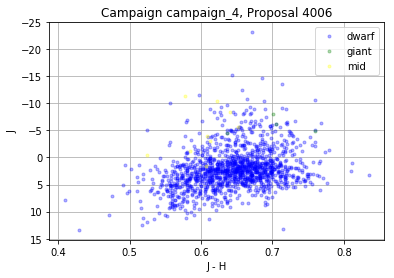

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


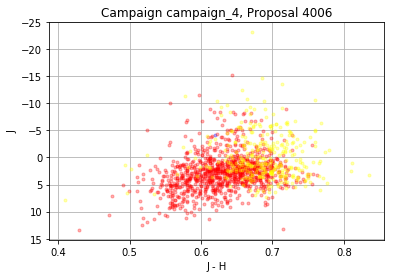

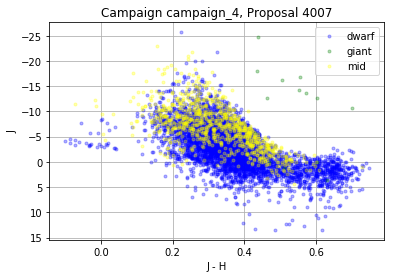

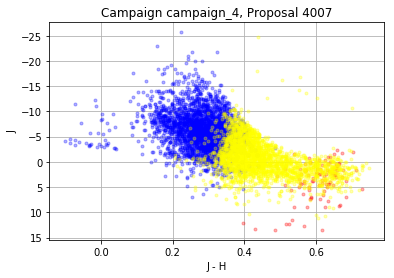

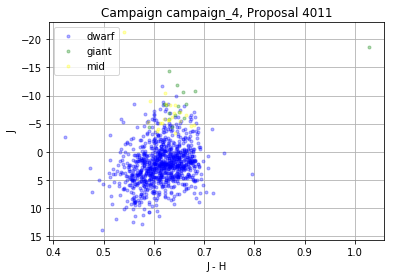

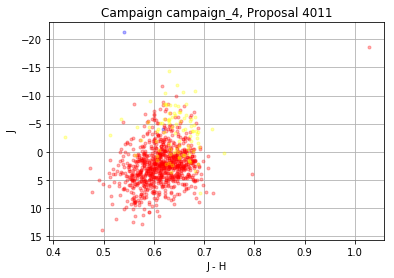

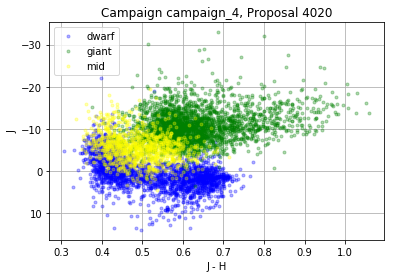

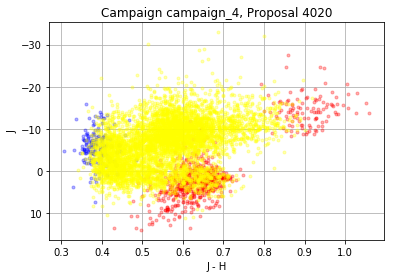

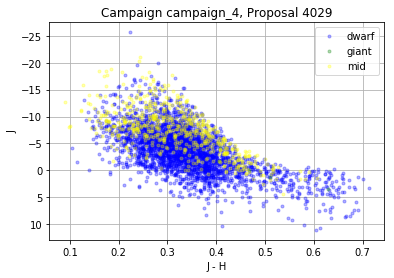

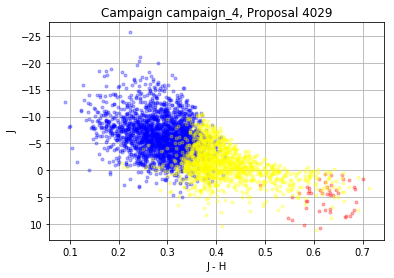

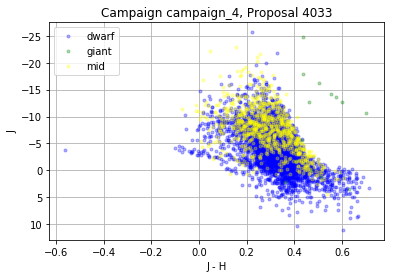

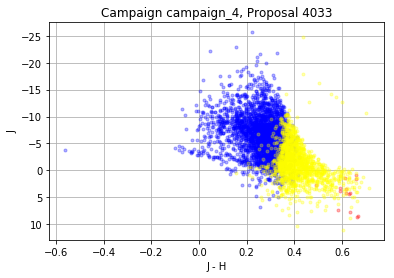

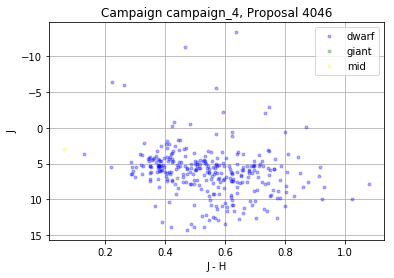

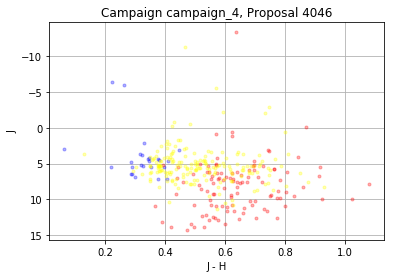

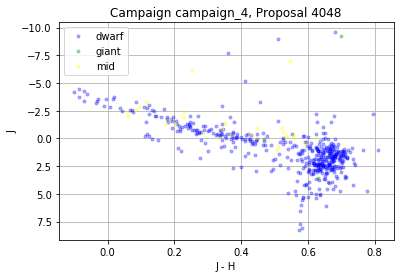

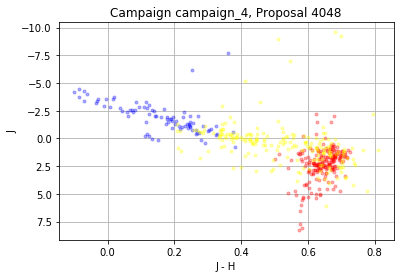

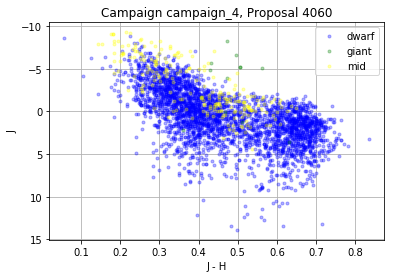

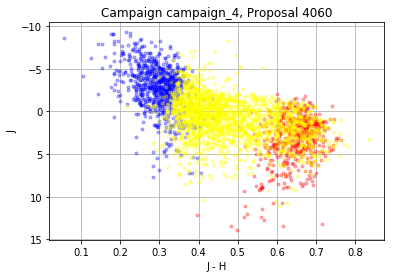

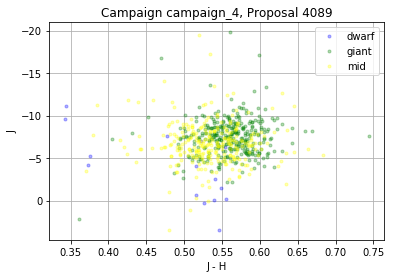

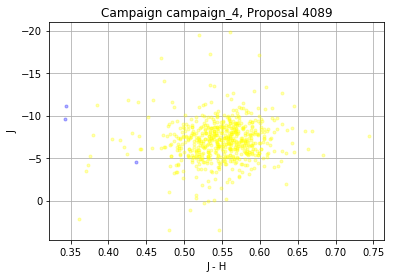

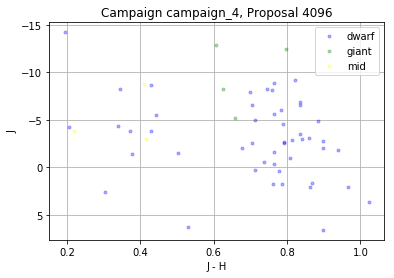

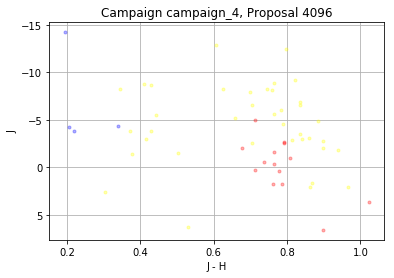

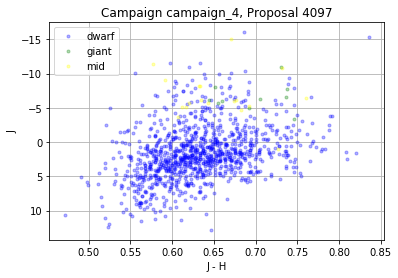

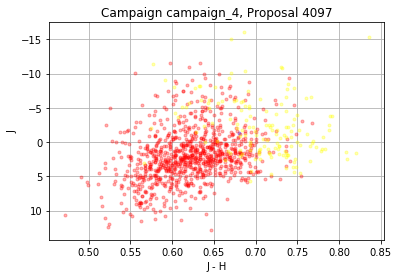

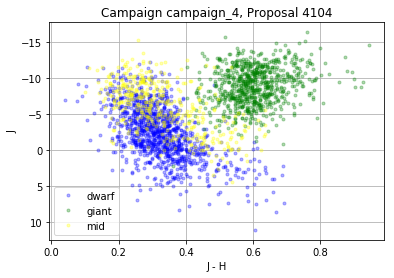

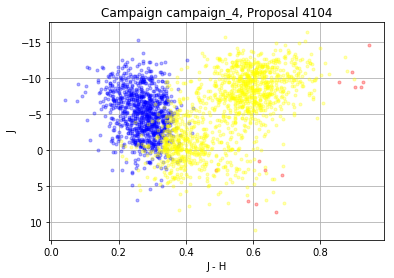

In [7]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

# Campaign 5

In [8]:
campaign_str = 'campaign_5'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

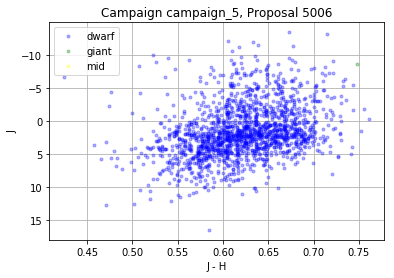

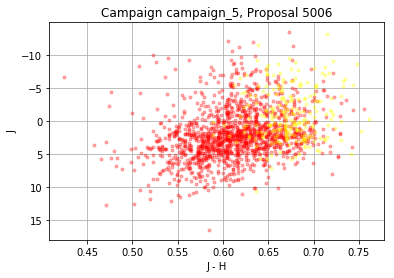

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


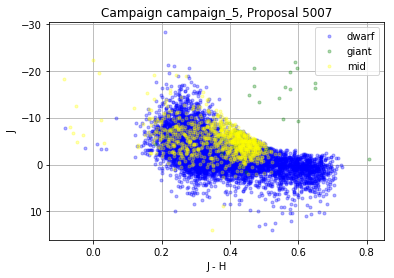

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


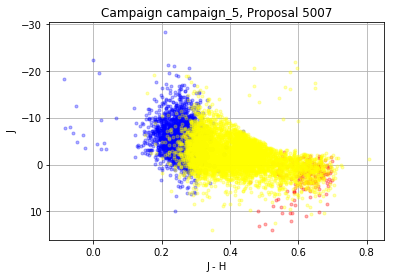

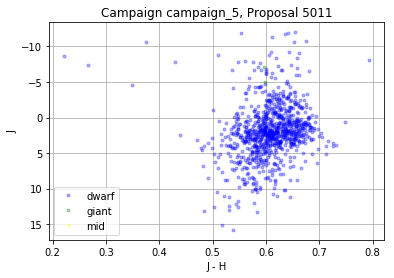

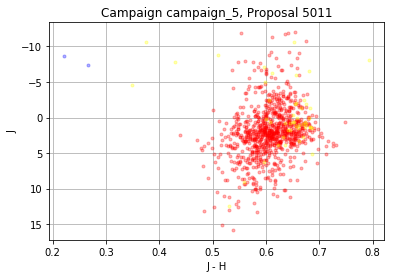

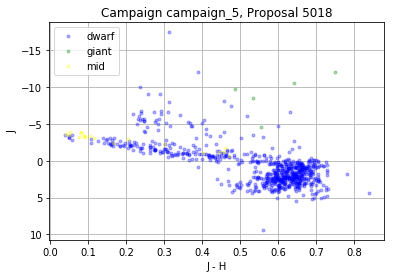

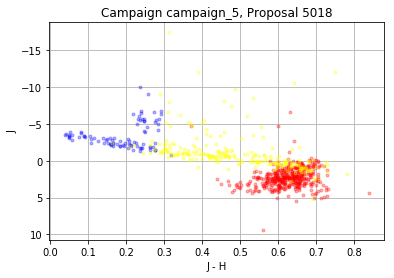

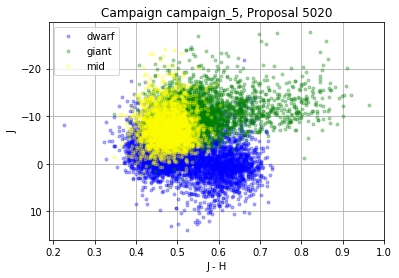

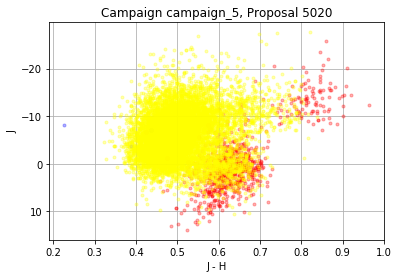

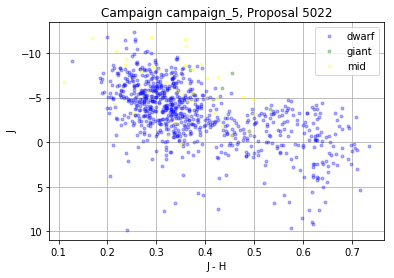

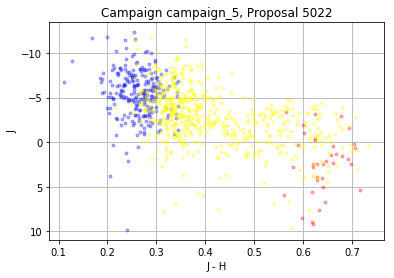

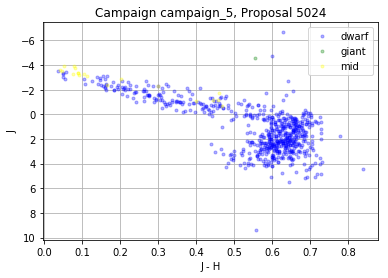

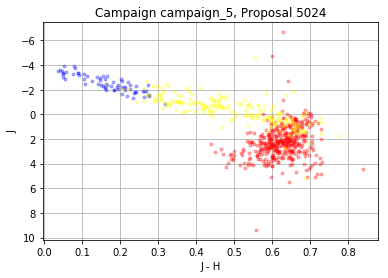

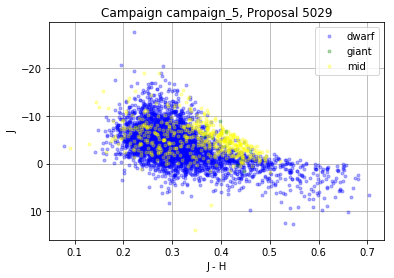

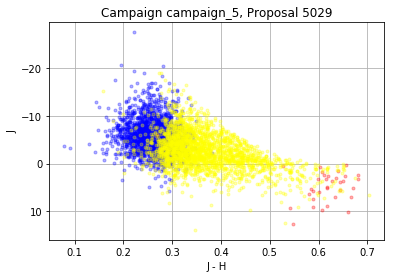

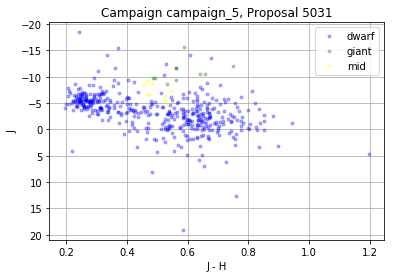

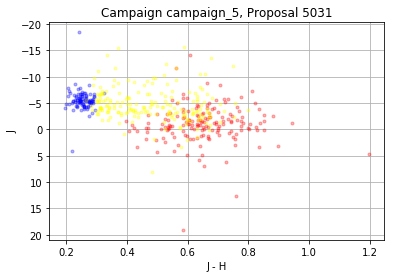

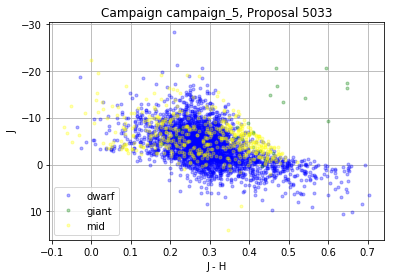

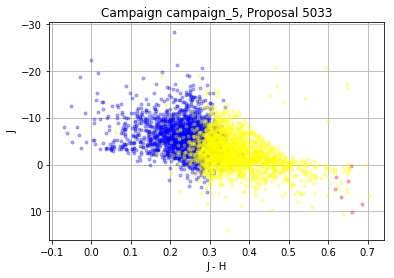

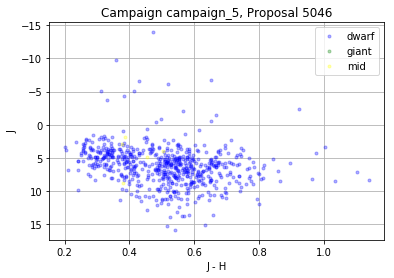

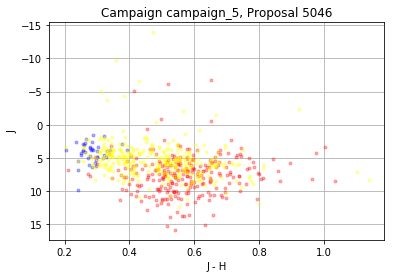

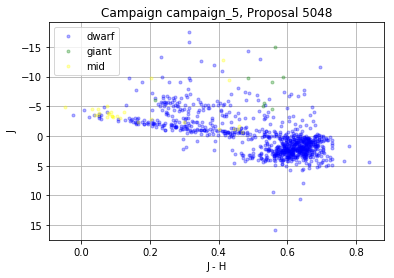

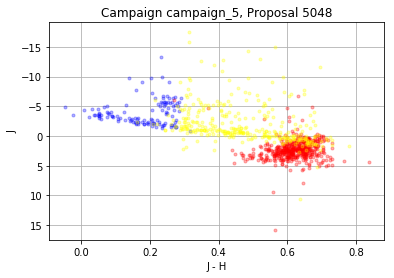

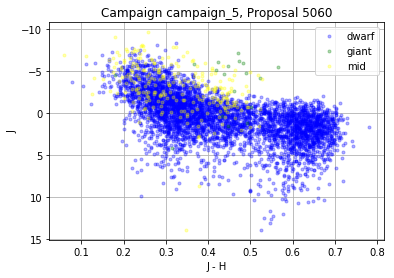

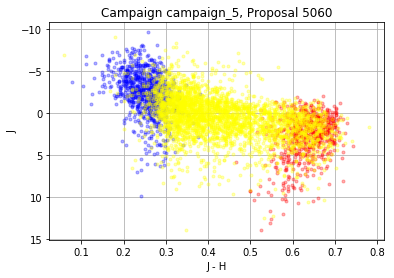

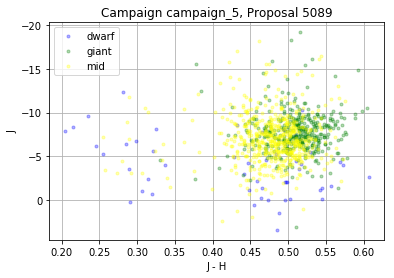

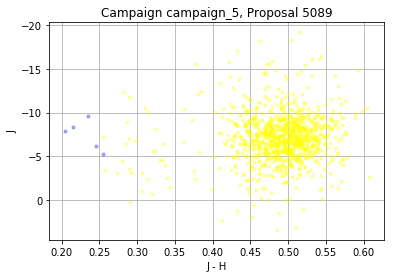

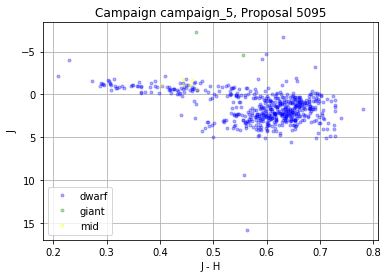

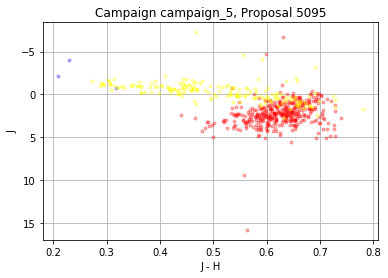

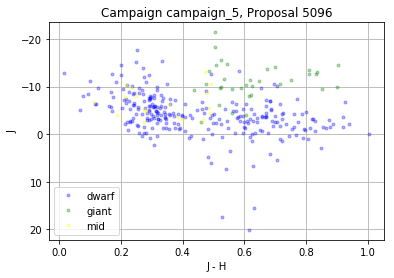

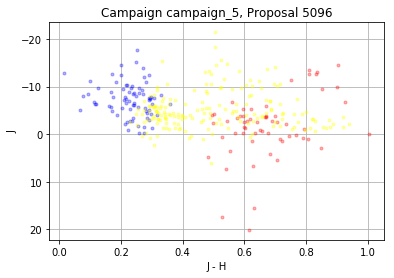

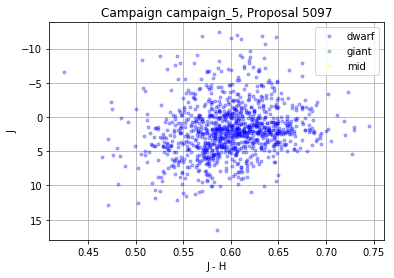

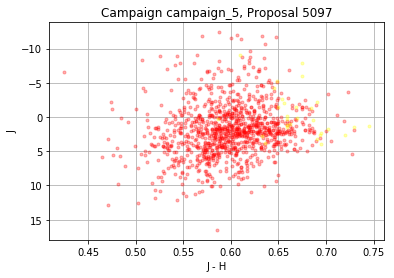

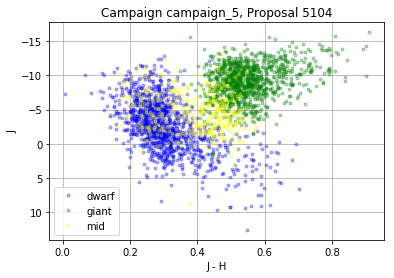

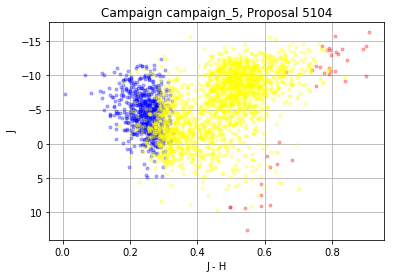

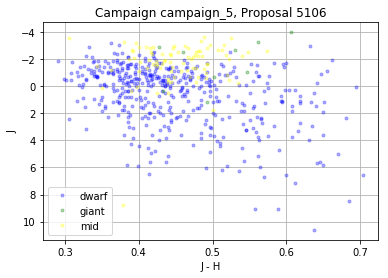

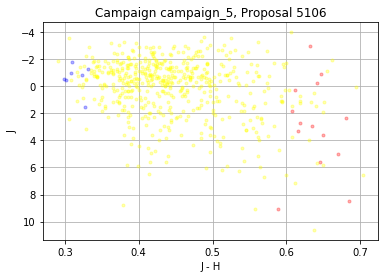

In [9]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

# Campaign 6

In [10]:
campaign_str = 'campaign_6'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [11]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 61 fields in line 740, saw 66


# Campaign 7

In [12]:
campaign_str = 'campaign_7'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


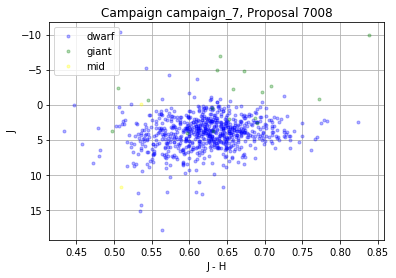

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


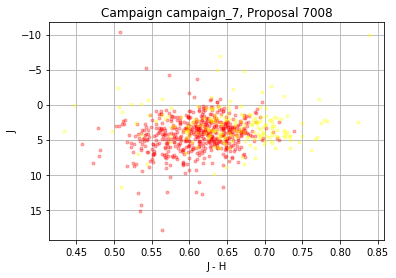

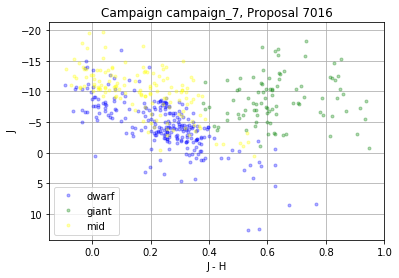

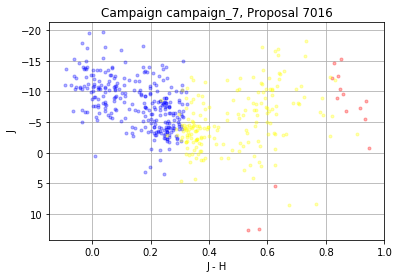

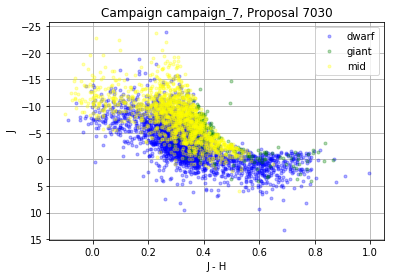

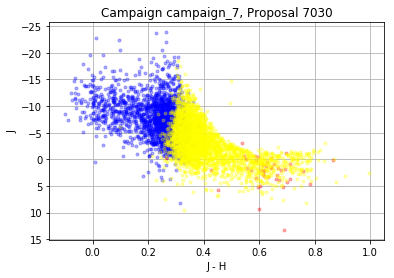

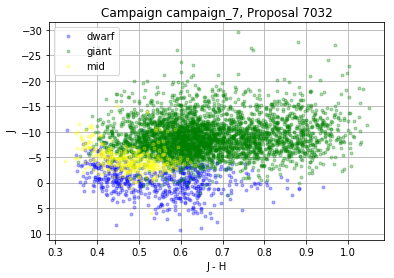

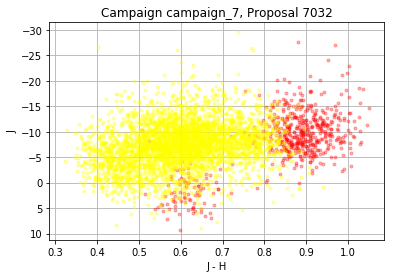

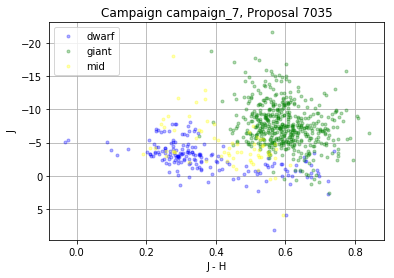

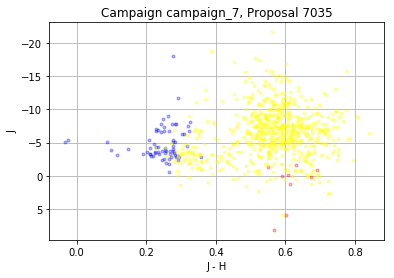

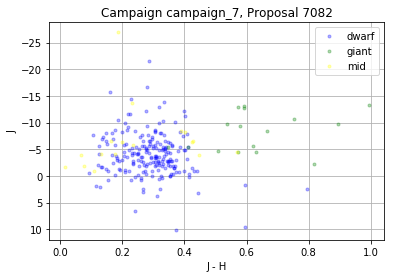

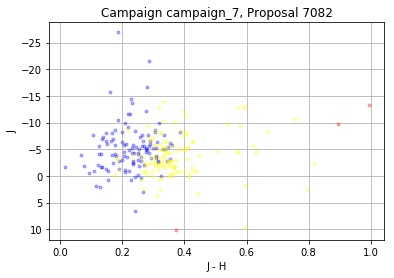

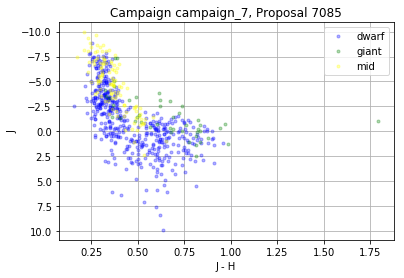

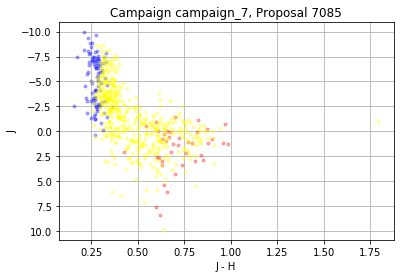

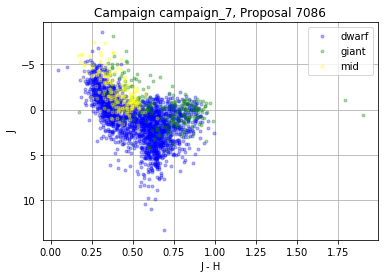

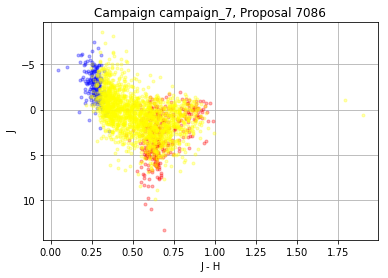

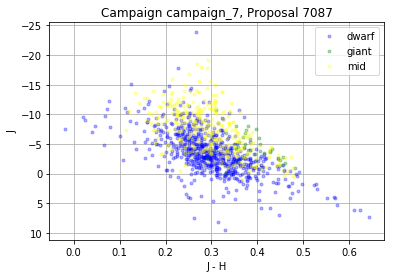

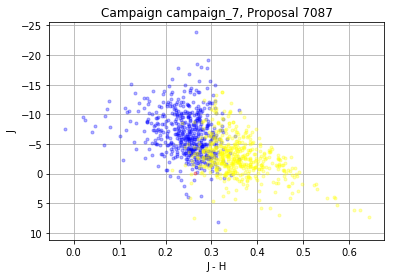

In [13]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

# Campaign 8


In [14]:
campaign_str = 'campaign_8'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

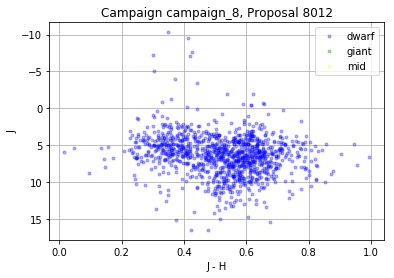

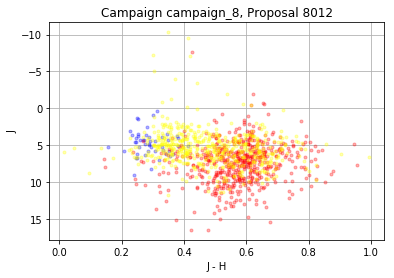

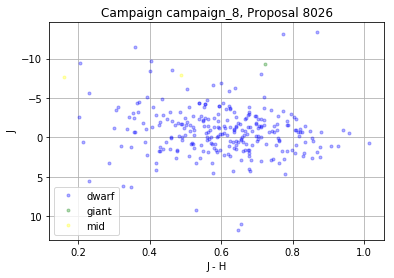

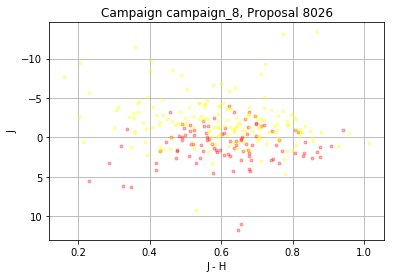

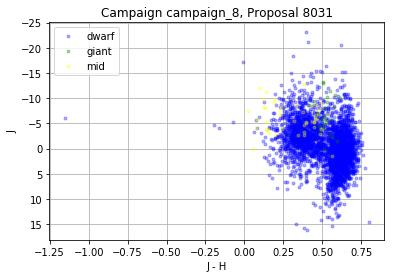

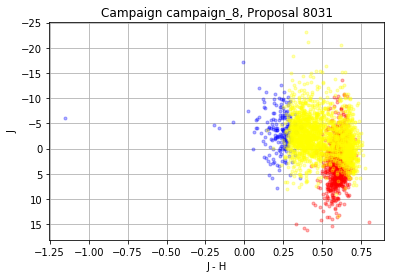

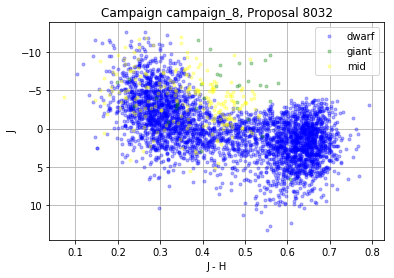

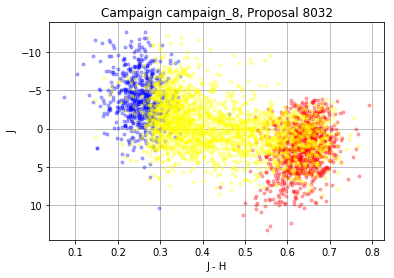

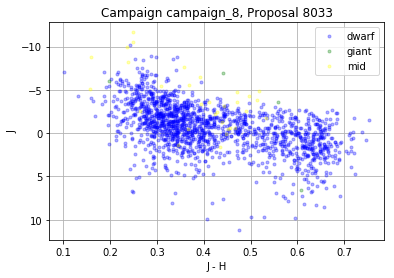

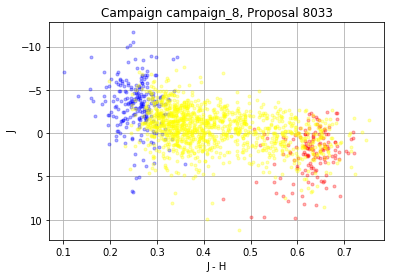

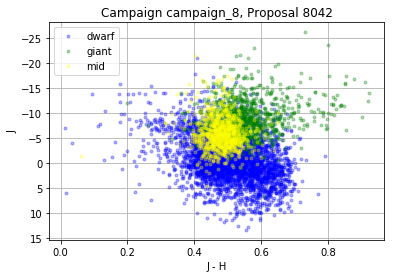

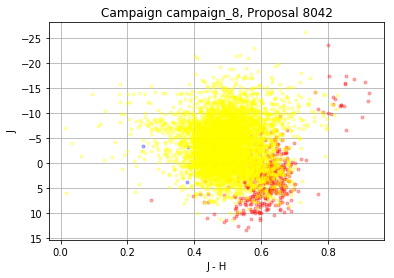

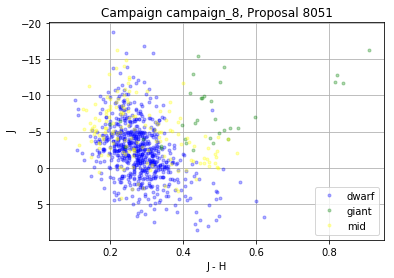

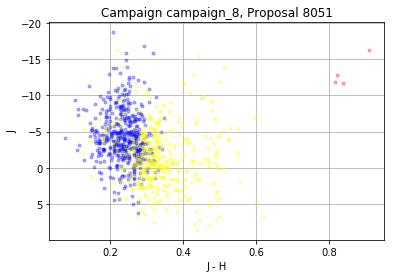

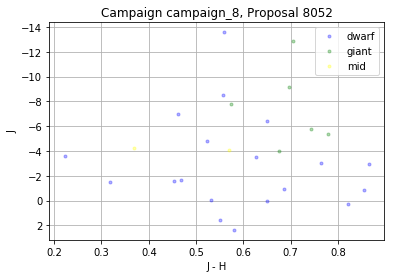

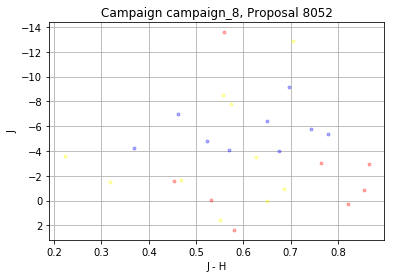

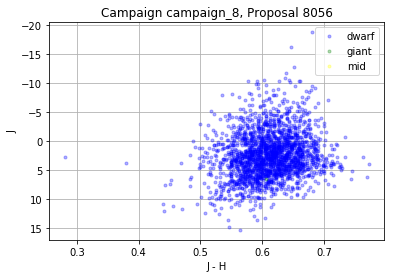

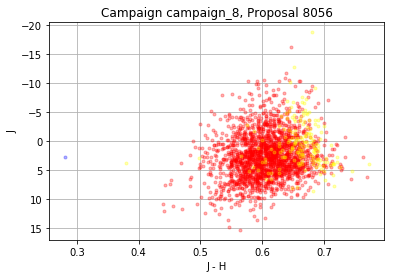

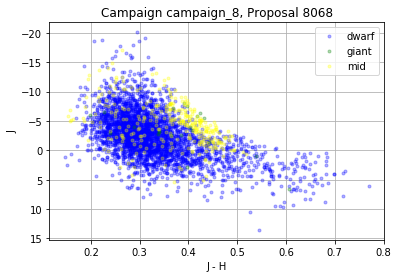

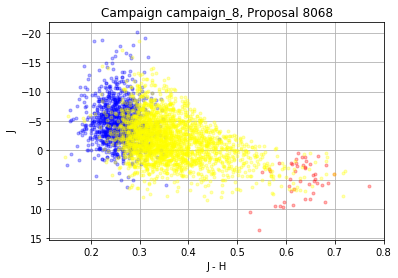

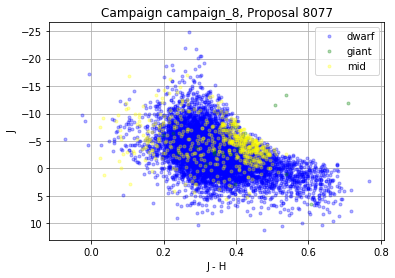

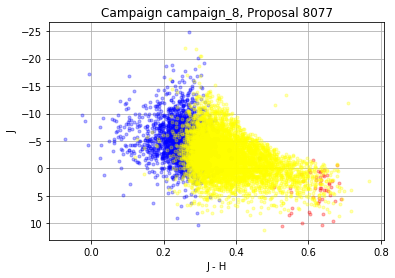

In [15]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

# Campaign 9a

In [18]:
campaign_str = 'campaign_9a'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [19]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

FileNotFoundError: File b'csv_files/campaign_9a/master_search.csv' does not exist

# Campaign 9b

In [20]:
campaign_str = 'campaign_9b'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [21]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

# Campaign 10

In [22]:
campaign_str = 'campaign_10'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [23]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 6 fields in line 6816, saw 12


# Campaign 11

In [24]:
campaign_str = 'campaign_11'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [25]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 61 fields in line 1401, saw 67


# Campaign 12

In [28]:
campaign_str = 'campaign_12'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [29]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 66 fields in line 3272, saw 72


# Campaign 13

In [30]:
campaign_str = 'campaign_13'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [31]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 66 fields in line 5266, saw 72


# Campaign 14

In [32]:
campaign_str = 'campaign_14'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [33]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 46 fields in line 873, saw 52


# Campaign 15

In [34]:
campaign_str = 'campaign_15'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [35]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 66 fields in line 8202, saw 69


# Campaign 16

In [36]:
campaign_str = 'campaign_16'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [37]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 66 fields in line 8202, saw 69


# Campaign 17

In [38]:
campaign_str = 'campaign_17'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [39]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 61 fields in line 8171, saw 69


# Campaign 18

In [40]:
campaign_str = 'campaign_18'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [41]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 63 fields in line 3520, saw 66


# Campaign 19

In [42]:
campaign_str = 'campaign_19'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [43]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

ParserError: Error tokenizing data. C error: Expected 66 fields in line 9713, saw 69


# Campaign 20

In [44]:
campaign_str = 'campaign_20'

#For each big proposal in the campaign, create a df so a color-magnitude plot
#can be made for each big df_big_proposal

big_prop_list = glob.glob('csv_files/%s/big_targets/*' %campaign_str)
temp = [x[-8:-4] for x in big_prop_list]
props_num = []
for i in range(len(temp)):
    try:
        int(temp[i][0])
        props_num.append(temp[i])
    except:
        pass

In [45]:
for proposal in props_num:
    make_logg_CM(campaign_str, int(proposal), 'logg_colored')
    make_temp_CM(campaign_str, int(proposal), 'Teff_colored')

FileNotFoundError: File b'csv_files/campaign_20/big_targets/prop_16.csv' does not exist